### Annual Rankings of Streamflow, SWE, ET, Soil Moisture, Precip (with anomalies)

This notebook will first build a linear regression between streamflow and SWE anomalies and compute the residual for these years and rank them. Then I will do the same for ranking years with annual ET signals, seasonal ET signals, winter, spring, and summer precip signals and fall soil moisture signals. Then I will look at how these years align with each other. 

This will cover the Water Years 1987 to 2020

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import datetime as dt

import rioxarray as rioxr
from rasterio.enums import Resampling
import geopandas as gpd 
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'

import seaborn as sns
import matplotlib.pyplot as plt
import xoak
import nctoolkit as nc
from dataretrieval import nwis
from scipy import stats


/tmp/ipykernel_10936/3956657037.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


1 file was created by nctoolkit in prior or current sessions. Consider running deep_clean!
nctoolkit is using Climate Data Operators version 2.1.0


In [2]:
# Polygon for Upper East River
upper_east_river_poly = gpd.read_file('./multisite/polygons/east_polygon.json')
upper_east_river_area = upper_east_river_poly.area # m^2

### Pull in Snotel data and streamflow data

In [3]:
# Climatology including precipitation, snowfall and temperature for each month
bb_climatology = pd.read_csv('../data/billy_barr_monthly_avg.csv',sep='\t')
bb_climatology[bb_climatology==" "] = np.nan
bb_climatology['WY'] = [int(str(year)[0:2]+str(year)[4:]) for year in bb_climatology['Year']]
bb_climatology['water_cm'] = bb_climatology['water_cm'].astype(float)
dates = pd.to_datetime([f"{bb_climatology.loc[i,'WY']}-{bb_climatology.loc[i,'Month']}-01" for i in bb_climatology.index], format='%Y-%m-%d')
date_list=[]

for i,date in enumerate(dates):
    if date.year == 1900:
        date = dt.date(2000,date.month,date.day)
    if date.month in [9,10,11,12]:
        date = dt.date(date.year-1,date.month,date.day)
    else:
        date = dt.date(date.year,date.month,date.day)
    date_list.append(date)
bb_climatology.index=date_list
bb_climatology = bb_climatology.drop(['Month', 'Year'], axis=1)
for col in bb_climatology:
    bb_climatology[col] = bb_climatology[col].astype(float)

In [4]:
# Import snotel data
er_sntl_data = xr.open_dataset('/storage/dlhogan/sos/data/east_river_sntl_20220930.nc')

In [5]:
er_usgs_almont = '09112500'

# get streamflow data from east river at almont
east_river_discharge_almont_dv = nwis.get_record(er_usgs_almont, start='1986-10-1', service='dv')['00060_Mean']

# Filter out until the end of our dataset
east_river_discharge_almont_dv = east_river_discharge_almont_dv.loc[:'2020-09-30']
# Filter out -9999 values
east_river_discharge_almont_dv = east_river_discharge_almont_dv[east_river_discharge_almont_dv>=0]

# Average to monthly values
east_river_discharge_almont_monthly = east_river_discharge_almont_dv.groupby(pd.Grouper(freq='M')).mean()
east_river_discharge_almont_monthly.index = pd.to_datetime(east_river_discharge_almont_monthly.index.date)

# Set index as datetime
east_river_discharge_almont_dv.index = pd.to_datetime(east_river_discharge_almont_dv.index).date

# Rename the series
east_river_discharge_almont_monthly.name = 'mean_discharge'
# Convert to dataframe and add in water year column
east_river_discharge_almont_monthly = east_river_discharge_almont_monthly.to_frame()
east_river_discharge_almont_monthly['WY'] = east_river_discharge_almont_monthly.index.year.where(east_river_discharge_almont_monthly.index.month < 10, east_river_discharge_almont_monthly.index.year + 1)

# create annual product
east_river_discharge_almont_annual = east_river_discharge_almont_monthly.groupby(east_river_discharge_almont_monthly['WY']).mean()

# create seasonal product 

# Wrap it into a simple function
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.index.dt.days_in_month

    # Calculate the weighted average
    return (ds * month_length).resample(index='QS-DEC').sum() / month_length.resample(index='QS-DEC').sum()

east_river_discharge_almont_monthly_ds = east_river_discharge_almont_monthly.to_xarray()
east_river_discharge_almont_seasonal_ds = season_mean(east_river_discharge_almont_monthly_ds)
east_river_discharge_almont_seasonal_ds['WY'] = np.ceil(east_river_discharge_almont_seasonal_ds['WY'])

### Linear relationship between Streamflow and SWE

In [6]:
# normalized streamflow
normalized_er_annual_q = (east_river_discharge_almont_annual - east_river_discharge_almont_annual.mean())/ east_river_discharge_almont_annual.std()

# normalized peak SWE
# create mean dataset for schofield and butte
butte_schofield_mean_ds = er_sntl_data.sel(Location=['Butte_380:CO:SNTL','SchofieldPass_737:CO:SNTL']).mean(dim='Location')
butte_schofield_mean_ds_filtered = butte_schofield_mean_ds.sel(Date=slice('1986-10-01', '2020-09-30'))
butte_schofield_mean_peak_swe = butte_schofield_mean_ds_filtered.WTEQ.groupby(butte_schofield_mean_ds_filtered.WY).max()
normalized_sntl_peak_swe = ((butte_schofield_mean_peak_swe - butte_schofield_mean_peak_swe.mean())/butte_schofield_mean_peak_swe.std()).to_dataframe()

In [7]:
stats.linregress(normalized_sntl_peak_swe['WTEQ'], normalized_er_annual_q['mean_discharge'])

LinregressResult(slope=0.9016817151315955, intercept=-5.678687943446015e-16, rvalue=0.9152415995606694, pvalue=3.535857860345499e-14, stderr=0.07016906367202129, intercept_stderr=0.07016906367202129)

In [8]:
slope, intercept, rvalue, pvalue,stderr  = stats.linregress(normalized_sntl_peak_swe['WTEQ'], normalized_er_annual_q['mean_discharge'])

alpha = 0.05
c = (1 - alpha)

# Create regression line and residuals
X = normalized_sntl_peak_swe['WTEQ']
y_predicted = intercept + slope*X
residual = (normalized_er_annual_q['mean_discharge']-y_predicted)

# Setup 
n = X.size                                               
dof = n - 2
t = stats.t.ppf(c, dof) 

# sum of squared errors
sse = np.sum(residual**2)

# total sum of squares (y)
sst = np.sum( (normalized_er_annual_q - np.mean(normalized_er_annual_q))**2 )

# total sum of squares (x)
sst_x = np.sum( (X - np.mean(X))**2 )

# correlation coefficient
r_squared = 1 - sse/sst

# standard error of regression
s = np.sqrt(sse/(n-2))

# an array of x values
p_x = np.linspace(X.min(),X.max(),100)

# using our model parameters to predict y values
p_y = intercept + slope*p_x

# compute error of prediction for each p_x
sigma_ep = np.sqrt( s**2 * (1+ 1/n + ( ( n*(p_x-X.mean(axis=None))**2 ) / ( n*np.sum(X**2) - np.sum(X)**2 ) ) ) )
# set our confidence interval

p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep


In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


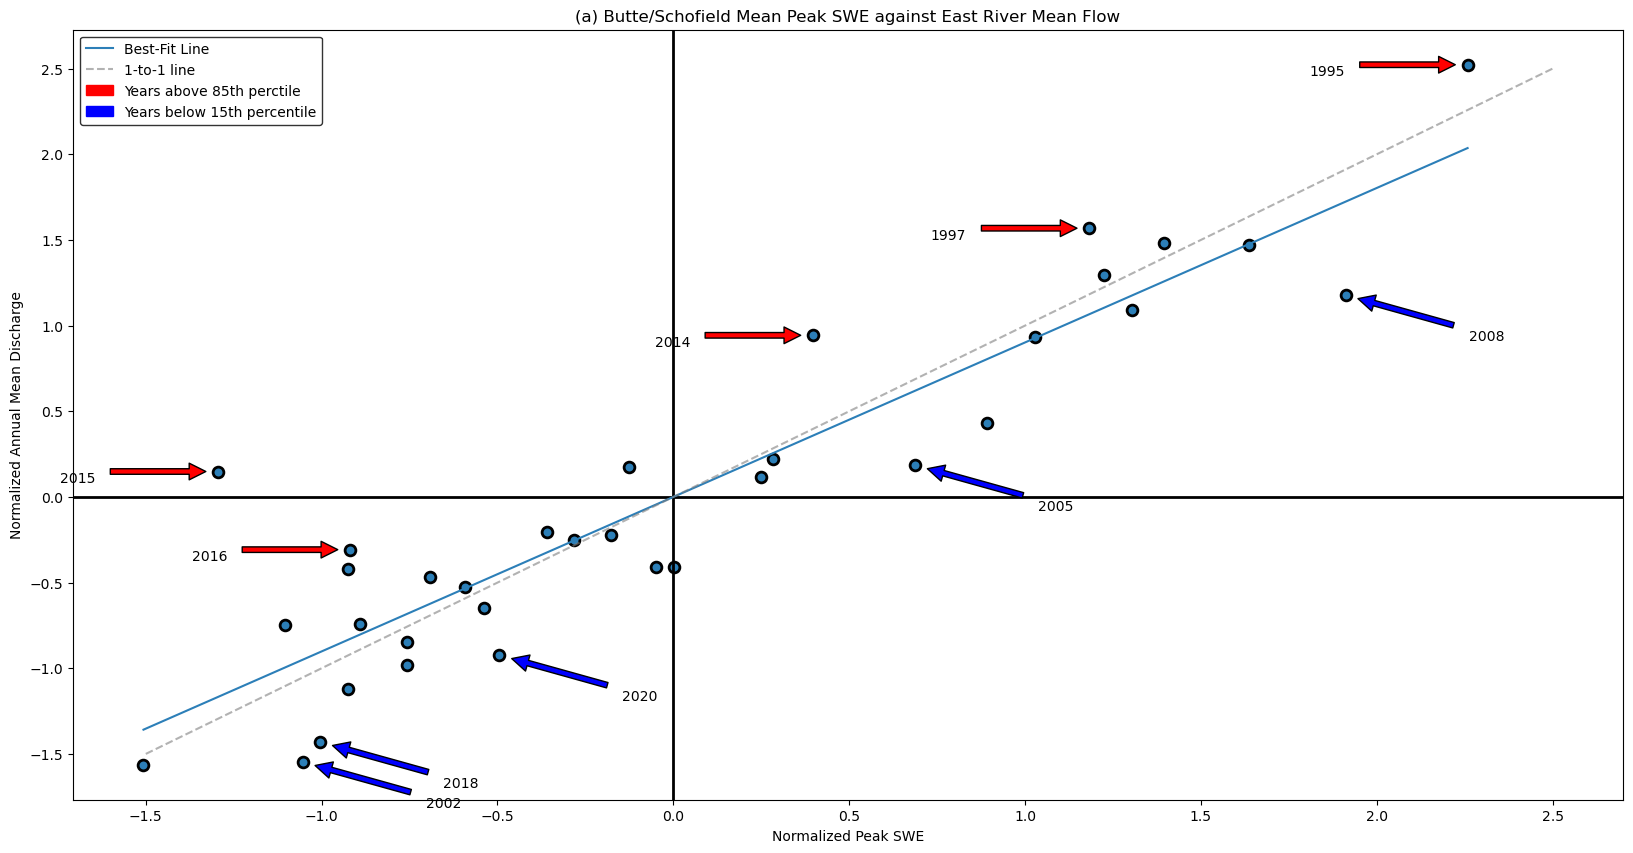

In [9]:
fig, ax = plt.subplots(ncols=1, figsize=(20,10))
colors = ['#2c7fb8','#7fcdbb']
residual=residual.dropna()
idx_15th_percentile = (residual[residual < np.percentile(residual,15)].index)
idx_85th_percentile = residual[residual > np.percentile(residual,85)].index

ax.scatter(normalized_sntl_peak_swe, normalized_er_annual_q, color=colors[0], edgecolor='k', s=60, lw=2)
ax.axhline(0, color='k', lw=2)
ax.axvline(0, color='k', lw=2)
ax.plot([X.min(),X.max()], intercept+slope*np.array([X.min(),X.max()]), color=colors[0], label='Best-Fit Line')
ax.plot([-1.5,2.5],[-1.5,2.5], label='1-to-1 line', color='grey', ls='--', alpha=0.6)
# ax.plot(p_x, p_y_lower, color=colors[1], ls='--', label='Upper/Lower 90% Confidence Bound')
# ax.plot(p_x, p_y_upper, color=colors[1], ls='--', )
# ax.fill_between(p_x, p_y_lower,p_y_upper, color=colors[1], alpha=0.3)


for i,idx in enumerate(idx_15th_percentile):

    ax.annotate(str(idx), 
                    (normalized_sntl_peak_swe.loc[idx], normalized_er_annual_q.loc[idx]),
                    (normalized_sntl_peak_swe.loc[idx]+0.4, normalized_er_annual_q.loc[idx]-0.2),
                    arrowprops=dict(facecolor='blue', shrink=0.1),
                    horizontalalignment='center', verticalalignment='top',)

for i,idx in enumerate(idx_85th_percentile):
    if idx == 2001:
        ax.annotate(str(idx), 
                (normalized_sntl_peak_swe.loc[idx], normalized_er_annual_q.loc[idx]),
                (normalized_sntl_peak_swe.loc[idx], normalized_er_annual_q.loc[idx]-0.4),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
        
    else:
        ax.annotate(str(idx), 
                (normalized_sntl_peak_swe.loc[idx], normalized_er_annual_q.loc[idx]),
                (normalized_sntl_peak_swe.loc[idx]-0.4, normalized_er_annual_q.loc[idx]),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)

ax.arrow([],[],[],[], color='red', label='Years above 85th perctile',width=0.1)
ax.arrow([],[],[],[], color='blue', label='Years below 15th percentile',width=0.1)
ax.set_xlabel('Normalized Peak SWE')
ax.set_ylabel('Normalized Annual Mean Discharge')
ax.set_title('(a) Butte/Schofield Mean Peak SWE against East River Mean Flow')
ax.legend(edgecolor='k', facecolor='white')




In [10]:
sorted_residual = residual.sort_values()

### Calculate snow melt season length and sort by years

In [43]:
# Butte SNTL dataset
butte_ds = er_sntl_data.sel(Location=['Butte_380:CO:SNTL'])

for year in butte_schofield_mean_ds_filtered.Date.dt.year:
    tmp = butte_schofield_mean_ds_filtered.where(butte_schofield_mean_ds_filtered.Date.dt.year==year)['WTEQ'].dropna(dim='Date')
    peak_swe_date = tmp.idxmax().values
    peak_swe = tmp.max()
    weekly_rolling_mean = tmp.rolling(Date=7).mean()
    snow_melt_date = weekly_rolling_mean.where(weekly_rolling_mean<0.05*peak_swe.values).dropna(dim='Date')[0].Date.values
    melt_season_length = snow_melt_date - peak_swe_date
    print(abs((melt_season_length- peak_swe_date).days))
        
# rolling weekly average is < 5% of Peak SWE


IndexError: index 0 is out of bounds for axis 0 with size 0

In [45]:
tmp = butte_schofield_mean_ds_filtered.where(butte_schofield_mean_ds_filtered.Date.dt.year==2020)['WTEQ'].dropna(dim='Date')
peak_swe_date = tmp.idxmax().values
peak_swe = tmp.max()
weekly_rolling_mean = tmp.rolling(Date=7).mean()
snow_melt_date = weekly_rolling_mean.where(weekly_rolling_mean<0.05*peak_swe.values).dropna(dim='Date')[0].Date.values
melt_season_length = snow_melt_date - peak_swe_date
print(abs((melt_season_length).days))

AttributeError: 'numpy.timedelta64' object has no attribute 'days'